In [74]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [19]:
sample_data=loadmat("/Users/abhivansh/Downloads/AC.mat")
sample_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Nov 21 21:17:46 2017',
 '__version__': '1.0',
 '__globals__': [],
 'tt': array([[0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
         0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
         0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
         0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
         0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
         0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
         0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
         0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
         0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
         0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
         0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
         0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 

In [20]:
sample_data['tt'],sample_data['uu']

(array([[0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
         0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
         0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
         0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
         0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
         0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
         0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
         0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
         0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
         0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
         0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
         0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
         0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
         0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 ,

In [35]:
typ=['uu','tt','x']
for i in typ:
    print(sample_data[i].shape)

(512, 201)
(1, 201)
(1, 512)


In [43]:
class pinn_model(nn.Module):
    def __init__(self,in_size,out_size,hidden_size):
        super(pinn_model,self).__init__()
        self.l1=nn.Linear(in_size,hidden_size)
        self.l2=nn.Linear(hidden_size,out_size)
    
    def forward(self,tt,uu):
        tt_expanded = tt.repeat(uu.shape[0], 1)  # Now tt_expanded is (512, 201)

        # Concatenate along the time axis (dim=1)
        x= torch.cat((tt_expanded, uu), dim=1)
        # x=torch.cat((tt,uu),dim=1)
        x=torch.relu(self.l1(x))
        x=self.l2(x)
        return x
    
    def physics_loss(self, tt, uu, x_pred):
        # x_t=torch.autograd.grad(x_pred,tt, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]
        # residual= x_t - f(tt, uu)
        # return torch.mean(residual**2)
    
        x_t = torch.autograd.grad(x_pred, tt, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]
        
        # Define the physical law as a function of time and input
        f = uu  # Example: assuming x_t = u(t), replace with your actual equation if different
        
        # Compute the residual of the physics-based equation
        residual = x_t - f
        
        # Return the mean squared error of the residual
        return torch.mean(residual ** 2)

In [44]:
def total_loss(x_pred,x_true,physics_loss):
    mse_loss=nn.MSELoss()(x_pred,x_true)
    total= mse_loss + physics_loss
    return total

In [87]:
in_size=402
out_size=1
hidden_size=128
epochs=100
model= pinn_model(in_size,out_size,hidden_size)
optimizer=optim.Adam(model.parameters(), lr=10e-4)

In [88]:
tt_tensor = torch.tensor(sample_data['tt'], dtype=torch.float32, requires_grad=True)
uu_tensor = torch.tensor(sample_data['uu'], dtype=torch.float32)
x_tensor = torch.tensor(sample_data['x'], dtype=torch.float32)
x_tensor = x_tensor.squeeze()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    pred_x = model(tt_tensor, uu_tensor)
    physics_residual = model.physics_loss(tt_tensor, uu_tensor, pred_x)
    
    loss = total_loss(pred_x, x_tensor, physics_residual)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 28.111295700073242
Epoch 1, Loss: 17.605070114135742
Epoch 2, Loss: 10.896219253540039
Epoch 3, Loss: 6.970529556274414
Epoch 4, Loss: 4.900319576263428
Epoch 5, Loss: 3.696741819381714
Epoch 6, Loss: 3.059095859527588
Epoch 7, Loss: 2.902592897415161
Epoch 8, Loss: 3.0520851612091064
Epoch 9, Loss: 3.1092426776885986
Epoch 10, Loss: 3.0787739753723145
Epoch 11, Loss: 3.0111851692199707
Epoch 12, Loss: 2.8600659370422363
Epoch 13, Loss: 2.682081937789917
Epoch 14, Loss: 2.7276906967163086
Epoch 15, Loss: 2.5588650703430176
Epoch 16, Loss: 2.3835301399230957
Epoch 17, Loss: 2.1842081546783447
Epoch 18, Loss: 1.9092435836791992
Epoch 19, Loss: 1.7149757146835327
Epoch 20, Loss: 1.572426199913025
Epoch 21, Loss: 1.4550378322601318
Epoch 22, Loss: 1.3823983669281006
Epoch 23, Loss: 1.3458198308944702
Epoch 24, Loss: 1.3249340057373047
Epoch 25, Loss: 1.3127148151397705
Epoch 26, Loss: 1.291321873664856
Epoch 27, Loss: 1.2494251728057861
Epoch 28, Loss: 1.1967484951019287
Epo

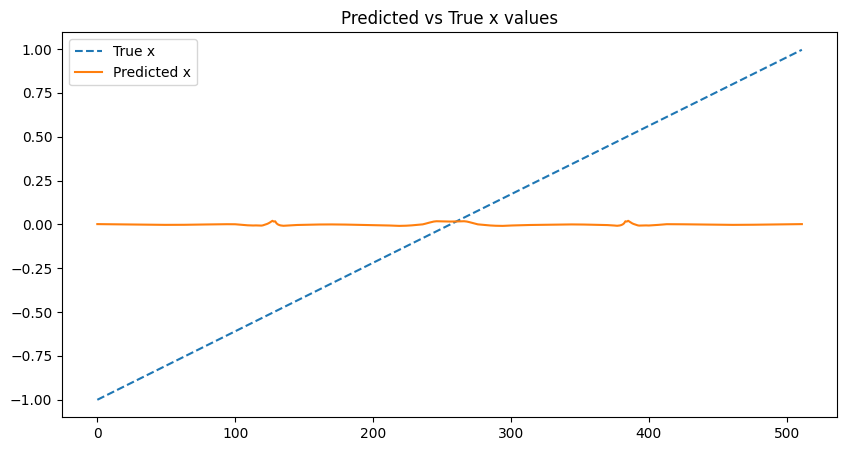

In [89]:
# Use Tensor's built-in data without converting to numpy
x_tensor_data = x_tensor.detach().cpu().tolist()
pred_x_data = pred_x.detach().cpu().tolist()

plt.figure(figsize=(10, 5))
plt.plot(x_tensor_data, label='True x', linestyle='--')
plt.plot(pred_x_data, label='Predicted x', linestyle='-')
plt.legend()
plt.title('Predicted vs True x values')
plt.show()